Two Options:
1. pooled_output from self.bert is (batch_size, seq_len, embedding_size). Basically, pooled_output can be viewed as a representation learned. Since this vector has the same seq_len as the input, we can do an aggregation over the third axis so that each token will have a score for heatmap.
2. directly back-prop to input_ids.

Original Notebook: https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S#scrollTo=PGnlRWvkY-2c


Bug for bert layers: https://github.com/huggingface/transformers/issues/1188

In [1]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 32.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.3 MB/s 
     |████████████████████████████████| 895 kB 66.9 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import cv2

import torch.nn.functional as F

In [3]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/11877-AMMML/"
DATASET_DIR = ROOT_DIR + "dataset/random/nlp/"

In [4]:
df = pd.read_csv(DATASET_DIR + "reviews.csv")
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
class TextDataset(Dataset):
  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      # pad_to_max_length=True,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [12]:
dataset = TextDataset(
    texts=df.content.to_numpy()[:3],
    targets=df.sentiment.to_numpy()[:3],
    tokenizer=tokenizer,
    max_len=160
  )

dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=1)

In [13]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, visualization="gradcam"):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # raw or gradcam
    self.visualization = visualization 

    # placeholder for the gradients
    self.gradients = None


  # hook for the gradients of the activations
  def activations_hook(self, grad):
    self.gradients = grad

  
  def forward(self, input_ids, attention_mask):
    self.raw_input = input_ids.clone().detach().cpu().numpy()
    if self.visualization == "raw":
      for module_pos, module in self.bert._modules.items():
        if module_pos == "embeddings":
          x = module(input_ids=input_ids)
          h = x.register_hook(self.activations_hook)
        elif module_pos == "encoder":
          x = module(hidden_states=x, attention_mask=attention_mask, head_mask=None, encoder_hidden_states=None, encoder_attention_mask=None).last_hidden_state
        else:
          pooled_output = module(hidden_states=x)
          last_hidden_state = x
    
    # last_hidden_state, pooled_output = self.bert(
    #   input_ids=input_ids,
    #   attention_mask=attention_mask
    # ) # We got a bunch of zero gradient problem because of the pooling operation, if we directly use last_hidden_state, this might be solved, but need retrain

    if self.visualization == "gradcam":
      h = last_hidden_state.register_hook(self.activations_hook)
    output = self.drop(pooled_output)
    return self.out(output)


  # method for the gradient extraction
  def get_activations_gradient(self):
      return self.gradients

  # method for the activation exctraction
  def get_activations(self, input_ids, attention_mask):
      if self.visualization == "gradcam":
        last_hidden_state, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return last_hidden_state.detach().cpu().numpy()
      elif self.visualization == "raw":
        return self.raw_input
      else:
        return None

  def get_raw_input(self):
    return self.raw_input

In [14]:
load_dict = torch.load(DATASET_DIR + 'sentiment.bin', map_location=torch.device('cpu'))

In [15]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names), "raw")
model.load_state_dict(load_dict, strict=False)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
model.eval()
data = next(iter(dataloader))

text = data["text"]
input_ids = data["input_ids"].to(device)
attention_mask = data["attention_mask"].to(device)
targets = data["targets"].to(device)

outputs = model(
  input_ids=input_ids,
  attention_mask=attention_mask
)

probs = F.softmax(outputs, dim=1)
_, preds = torch.max(outputs, dim=1)

pred_index = preds.detach().cpu().numpy()[0]

print("Input text is", text)
print("Length of input_ids is", len(input_ids[0]))
print("Input tokens are", tokenizer.convert_ids_to_tokens(input_ids[0]))
print("Ground truth label is", class_names[targets.detach().cpu().numpy()[0]])
print("Prediction is", class_names[pred_index])

Input text is ['A little confusing to navigate at first but otherwise useful']
Length of input_ids is 160
Input tokens are ['[CLS]', 'A', 'little', 'confusing', 'to', 'navigate', 'at', 'first', 'but', 'otherwise', 'useful', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [20]:
outputs[:, pred_index].backward()

#### Check gradients

In [21]:
gradients = model.get_activations_gradient()

In [22]:
pooled_gradients = torch.mean(gradients, dim=2)

In [24]:
pooled_gradients_np = pooled_gradients.detach().cpu().numpy()

In [26]:
np.argmax(pooled_gradients_np)

10

In [27]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens[np.argmax(pooled_gradients_np) - 2 : np.argmax(pooled_gradients_np) + 2]

['but', 'otherwise', 'useful', '[SEP]']

In [29]:
tokens[np.argmax(pooled_gradients_np)]

'useful'

#### Check Activations

In [39]:
raw_activations = model.get_activations(input_ids, attention_mask)

In [40]:
activations = np.zeros(raw_activations.shape)

In [41]:
for i in range(activations[0].shape[0]):
  activations[:, i] = raw_activations[:, i] * pooled_gradients_np[:, i]

In [43]:
np.argmax(activations)

10

In [ ]:
heatmap = activations

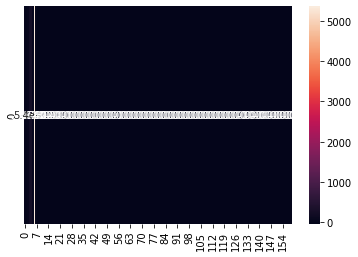

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(heatmap*1255, annot=True)
plt.show()